In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset,TensorDataset
from sklearn.model_selection import KFold
from learning_tool import *
import sys
sys.path.append('..')

from model.model import *

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm.notebook import tqdm
from IPython.display import display
from sklearn.model_selection import train_test_split

In [3]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [4]:
# デバイスの割り当て

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device('cpu')

cuda:0


In [5]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
# 乱数初期化
torch_seed()

In [6]:
df = pd.read_csv('../resource/txt_vec_and_label_camel_0.csv', index_col=0)
df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,contains_bug
commit_hash,,,,,,,,,,,,,,,,,,,,,
77b260b65ba821b3443d922320cc3d9b708c8d83,5,5,25,36,16,23,6,7,11,5,...,6,92,7,1,11,1,5,1,34,1
a4701ac4bf5b50810914796e284b0e3f78a240bc,5,25,36,16,23,6,7,11,5,161,...,0,0,0,0,0,0,0,0,0,1
0a0bad2c4a35be88f7732def261a03737fab662e,5,25,36,16,23,6,7,11,5,681,...,0,0,0,0,0,0,0,0,0,1
4de90eba5a4628f573c5e0536ed9160b6f1ea29d,374,16,23,6,7,11,5,122,65,122,...,0,0,0,0,0,0,0,0,0,0
4292f69f0afd36a7335515cc565ea41521bfa5cd,5,25,36,16,23,6,7,11,5,34,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
da0d0426ebf80387c4eb5f169bed5df813dd22da,5,25,36,16,23,6,7,11,5,17,...,0,0,0,0,0,0,0,0,0,0
f3f792e763685511088a10afb2d58a75ac131421,5,25,36,16,23,6,7,11,5,5,...,3,4,18,32,13,5,0,821,1034,1
f59887aeaf409d5282548a5d559f5ce58c43c601,5,25,36,16,23,6,7,11,5,124,...,0,0,0,0,0,0,0,0,0,1


In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, features, labels):
        self.features_values = df[features].values
        self.labels = df[labels].values
        
    # len()を使用すると呼ばれる
    def __len__(self):
        return len(self.features_values)

    # 要素を参照すると呼ばれる関数    
    def __getitem__(self, idx):
        features_x = torch.LongTensor(self.features_values[idx])
        labels = torch.as_tensor(self.labels[idx])
        return features_x, labels

In [8]:
columns = df.columns.values
features_columns = columns[:-1]
labels_column = columns[-1]
print(features_columns)
print(labels_column)
dataset = MyDataset(df, features_columns, labels_column)

['0' '1' '2' ... '1997' '1998' '1999']
contains_bug


In [9]:
df['contains_bug'].value_counts() / df.shape[0]

contains_bug
0    0.630281
1    0.369719
Name: count, dtype: float64

In [10]:
len(dataset[0][0])

2000

In [11]:
n_output = 2
n_hidden = 100
print(f'n_hidden: {n_hidden} n_output: {n_output}')

n_hidden: 100 n_output: 2


In [12]:
def undersampling(dataset):
    target = np.zeros(0)
    target = (np.hstack(data[1].numpy() for data in dataset))
    print (
        'original target  0/1: {}/{}'.format(
        len(np.where(target == 0)[0]), len(np.where(target == 1)[0]))
    )
    
    class_indices = [np.where(target == t)[0] for t in np.unique(target)]
    class_sample_count = np.array([len(idx) for idx in class_indices])
    min_class_idx = np.argmin(class_sample_count)
    max_class_idx = np.argmax(class_sample_count)
    undersample_indices = np.random.choice(class_indices[max_class_idx], size=int(min(class_sample_count)), replace=False)
    combined_indices = np.hstack([class_indices[min_class_idx], undersample_indices])
    
    features = dataset[combined_indices][0]
    labels = dataset[combined_indices][1]
    
    shuffle_indices = torch.randperm(len(features))
    features = features[shuffle_indices]
    labels = labels[shuffle_indices]
    
    undersampled_dataset = torch.utils.data.TensorDataset(features, labels)
    
    target = np.zeros(0)
    target = (np.hstack(data[1].numpy() for data in undersampled_dataset))
    print (
        'undersampled target  0/1: {}/{}'.format(
        len(np.where(target == 0)[0]), len(np.where(target == 1)[0]))
    )
    return undersampled_dataset
undersampling(dataset)

original target  0/1: 16335/9582
undersampled target  0/1: 9582/9582


In [13]:
# 学習率
lr = 0.001

# 繰り返し回数
num_epochs = 20

# 評価結果記録用
cv_history = np.zeros((0,6))
each_history = np.zeros((0,num_epochs,6))

batch_size = 66
num_splits = 10
kf = KFold(n_splits=num_splits)
cv_cnt = 0

# random_seed_list = [100,101,102,103,104,105,106,107,108,109,110]
# for seed in random_seed_list:
#     torch_seed(seed)
undersampled_dataset = undersampling(dataset)

for train_index, test_index in kf.split(undersampled_dataset):
    cv_cnt += 1
    history = np.zeros((0,6))
    train_dataset = Subset(undersampled_dataset, train_index)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
    test_dataset   = Subset(undersampled_dataset, test_index)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2)
    
    # モデルインスタンス生成
    net = CNN(n_output, n_hidden).to(device)
    # net._initialize_weights()
    # 最適化関数: 勾配降下法
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.001)
    # optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 損失関数： 交差エントロピー関数
    criterion = nn.CrossEntropyLoss()
    
    #学習
    history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history, test_dataset)
    
    #1交差ごとの記録
    each_history = np.vstack((each_history, [history]))
    cv_avg_train_loss = np.average(history[:,1])
    cv_train_acc = np.average(history[:,2])
    cv_avg_val_loss = np.average(history[:,3])
    cv_val_acc = np.average(history[:,4])
    cv_avg_auc = np.average(history[:,5])
    item = np.array([cv_cnt, cv_avg_train_loss, cv_train_acc, cv_avg_val_loss, cv_val_acc, cv_avg_auc])
    cv_history = np.vstack((cv_history, item))
    print(f'CV [{cv_cnt}/{num_splits}], loss: {cv_avg_train_loss:.5f} acc: {cv_train_acc:.5f} val_loss: {cv_avg_val_loss:.5f}, val_acc: {cv_val_acc:.5f}, auc_score: {cv_avg_auc:.5f}')

original target  0/1: 16335/9582
undersampled target  0/1: 9582/9582


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.59395 acc: 0.68760 val_loss: 0.56656, val_acc: 0.70318, auc_score: 0.77453


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.53821 acc: 0.72702 val_loss: 0.56044, val_acc: 0.70683, auc_score: 0.77648


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.51065 acc: 0.74738 val_loss: 0.55868, val_acc: 0.71153, auc_score: 0.78116


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.49651 acc: 0.75770 val_loss: 0.55893, val_acc: 0.70788, auc_score: 0.78502


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.47181 acc: 0.77764 val_loss: 0.56592, val_acc: 0.70214, auc_score: 0.78713


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.45777 acc: 0.78953 val_loss: 0.56225, val_acc: 0.71570, auc_score: 0.78711


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.44805 acc: 0.79533 val_loss: 0.56133, val_acc: 0.71414, auc_score: 0.78468


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.44410 acc: 0.79898 val_loss: 0.55894, val_acc: 0.70788, auc_score: 0.78798


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.43918 acc: 0.80692 val_loss: 0.55268, val_acc: 0.71622, auc_score: 0.79103


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.43820 acc: 0.80571 val_loss: 0.56864, val_acc: 0.70266, auc_score: 0.79365


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.44338 acc: 0.80159 val_loss: 0.56378, val_acc: 0.71622, auc_score: 0.79105


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.44281 acc: 0.80072 val_loss: 0.55507, val_acc: 0.71935, auc_score: 0.78873


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.44382 acc: 0.80078 val_loss: 0.55357, val_acc: 0.71883, auc_score: 0.79158


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.44693 acc: 0.79585 val_loss: 0.55613, val_acc: 0.71935, auc_score: 0.78794


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.44445 acc: 0.79881 val_loss: 0.57035, val_acc: 0.70579, auc_score: 0.78926


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.44403 acc: 0.79892 val_loss: 0.55145, val_acc: 0.72770, auc_score: 0.79219


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.43851 acc: 0.80391 val_loss: 0.56680, val_acc: 0.71622, auc_score: 0.78689


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.43564 acc: 0.80408 val_loss: 0.55903, val_acc: 0.72353, auc_score: 0.78938


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.42735 acc: 0.80779 val_loss: 0.55944, val_acc: 0.71674, auc_score: 0.78982


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.41738 acc: 0.81626 val_loss: 0.57247, val_acc: 0.70527, auc_score: 0.78833
CV [1/10], loss: 0.46114 acc: 0.78613 val_loss: 0.56112, val_acc: 0.71286, auc_score: 0.78720


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.59365 acc: 0.68795 val_loss: 0.55755, val_acc: 0.71674, auc_score: 0.78372


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.54093 acc: 0.72384 val_loss: 0.58762, val_acc: 0.67501, auc_score: 0.79106


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.51465 acc: 0.74540 val_loss: 0.60796, val_acc: 0.65884, auc_score: 0.79323


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.49708 acc: 0.75810 val_loss: 0.54148, val_acc: 0.72666, auc_score: 0.80044


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.47186 acc: 0.77828 val_loss: 0.55265, val_acc: 0.72248, auc_score: 0.79607


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.45963 acc: 0.78883 val_loss: 0.56834, val_acc: 0.69953, auc_score: 0.79760


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.44856 acc: 0.79927 val_loss: 0.54036, val_acc: 0.71883, auc_score: 0.80087


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.44388 acc: 0.80449 val_loss: 0.53899, val_acc: 0.73761, auc_score: 0.80467


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.43855 acc: 0.80431 val_loss: 0.54230, val_acc: 0.71570, auc_score: 0.79978


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.43914 acc: 0.80588 val_loss: 0.53651, val_acc: 0.72405, auc_score: 0.80577


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.43617 acc: 0.81029 val_loss: 0.55553, val_acc: 0.70840, auc_score: 0.80725


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.44047 acc: 0.80576 val_loss: 0.53878, val_acc: 0.72561, auc_score: 0.80400


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.44104 acc: 0.80460 val_loss: 0.53576, val_acc: 0.72770, auc_score: 0.80648


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.44288 acc: 0.79939 val_loss: 0.53837, val_acc: 0.73031, auc_score: 0.80695


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.44237 acc: 0.80321 val_loss: 0.53473, val_acc: 0.73187, auc_score: 0.80903


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.43889 acc: 0.80478 val_loss: 0.53269, val_acc: 0.73552, auc_score: 0.80935


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.43486 acc: 0.80733 val_loss: 0.56016, val_acc: 0.70944, auc_score: 0.80844


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.42816 acc: 0.81174 val_loss: 0.54028, val_acc: 0.71987, auc_score: 0.81007


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.41986 acc: 0.81603 val_loss: 0.53689, val_acc: 0.73396, auc_score: 0.80989


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.41152 acc: 0.82061 val_loss: 0.54105, val_acc: 0.72144, auc_score: 0.80361
CV [2/10], loss: 0.45921 acc: 0.78900 val_loss: 0.54940, val_acc: 0.71698, auc_score: 0.80241


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.59275 acc: 0.68522 val_loss: 0.58278, val_acc: 0.69588, auc_score: 0.76947


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.54424 acc: 0.72366 val_loss: 0.57397, val_acc: 0.70527, auc_score: 0.77670


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.51881 acc: 0.74448 val_loss: 0.55991, val_acc: 0.71101, auc_score: 0.78113


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.49775 acc: 0.75613 val_loss: 0.55672, val_acc: 0.71205, auc_score: 0.78658


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.47694 acc: 0.77579 val_loss: 0.57356, val_acc: 0.71309, auc_score: 0.78771


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.46389 acc: 0.78576 val_loss: 0.55746, val_acc: 0.71466, auc_score: 0.78514


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.45193 acc: 0.79724 val_loss: 0.57790, val_acc: 0.70683, auc_score: 0.78870


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.44976 acc: 0.79695 val_loss: 0.55717, val_acc: 0.71518, auc_score: 0.79084


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.44344 acc: 0.80692 val_loss: 0.56293, val_acc: 0.71153, auc_score: 0.78859


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.44231 acc: 0.80594 val_loss: 0.55083, val_acc: 0.71257, auc_score: 0.79369


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.44565 acc: 0.80014 val_loss: 0.56023, val_acc: 0.70892, auc_score: 0.78741


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.44774 acc: 0.79950 val_loss: 0.55401, val_acc: 0.71101, auc_score: 0.79108


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.44822 acc: 0.79608 val_loss: 0.55877, val_acc: 0.71570, auc_score: 0.79328


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.44959 acc: 0.79567 val_loss: 0.55717, val_acc: 0.71362, auc_score: 0.79171


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.44851 acc: 0.79504 val_loss: 0.55040, val_acc: 0.71727, auc_score: 0.79476


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.44735 acc: 0.79828 val_loss: 0.55749, val_acc: 0.71257, auc_score: 0.79253


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.44445 acc: 0.80037 val_loss: 0.55534, val_acc: 0.71101, auc_score: 0.78973


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.43838 acc: 0.80026 val_loss: 0.55715, val_acc: 0.70996, auc_score: 0.79149


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.43152 acc: 0.80704 val_loss: 0.55358, val_acc: 0.71362, auc_score: 0.79200


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.42630 acc: 0.81069 val_loss: 0.57039, val_acc: 0.71101, auc_score: 0.79042
CV [3/10], loss: 0.46548 acc: 0.78406 val_loss: 0.56139, val_acc: 0.71114, auc_score: 0.78815


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.59724 acc: 0.68667 val_loss: 0.54381, val_acc: 0.71674, auc_score: 0.79740


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.53856 acc: 0.72726 val_loss: 0.54298, val_acc: 0.71414, auc_score: 0.80310


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.51505 acc: 0.74367 val_loss: 0.54203, val_acc: 0.72979, auc_score: 0.80470


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.49651 acc: 0.76083 val_loss: 0.53426, val_acc: 0.72822, auc_score: 0.80319


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.47307 acc: 0.77845 val_loss: 0.53468, val_acc: 0.71987, auc_score: 0.80394


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.46380 acc: 0.78825 val_loss: 0.53493, val_acc: 0.72718, auc_score: 0.80776


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.45039 acc: 0.79846 val_loss: 0.54038, val_acc: 0.71674, auc_score: 0.79865


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.44570 acc: 0.80356 val_loss: 0.53503, val_acc: 0.72770, auc_score: 0.80689


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.44194 acc: 0.80692 val_loss: 0.53641, val_acc: 0.71987, auc_score: 0.80482


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.44190 acc: 0.80733 val_loss: 0.55364, val_acc: 0.72718, auc_score: 0.80692


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.44363 acc: 0.80721 val_loss: 0.54490, val_acc: 0.72405, auc_score: 0.80653


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.44857 acc: 0.79898 val_loss: 0.53905, val_acc: 0.72561, auc_score: 0.80649


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.44678 acc: 0.80130 val_loss: 0.53824, val_acc: 0.72770, auc_score: 0.80374


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.44893 acc: 0.79689 val_loss: 0.53486, val_acc: 0.73552, auc_score: 0.80470


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.45172 acc: 0.79301 val_loss: 0.54805, val_acc: 0.72926, auc_score: 0.80696


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.44652 acc: 0.79602 val_loss: 0.54214, val_acc: 0.71466, auc_score: 0.80597


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.44191 acc: 0.80257 val_loss: 0.54304, val_acc: 0.72144, auc_score: 0.79951


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.43724 acc: 0.80414 val_loss: 0.54059, val_acc: 0.72457, auc_score: 0.80212


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.42922 acc: 0.80907 val_loss: 0.56489, val_acc: 0.71414, auc_score: 0.79572


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.41865 acc: 0.81672 val_loss: 0.54676, val_acc: 0.73552, auc_score: 0.80390
CV [4/10], loss: 0.46387 acc: 0.78637 val_loss: 0.54203, val_acc: 0.72400, auc_score: 0.80365


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.59269 acc: 0.68675 val_loss: 0.59224, val_acc: 0.68998, auc_score: 0.76340


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.54000 acc: 0.72832 val_loss: 0.58120, val_acc: 0.70355, auc_score: 0.77109


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.51493 acc: 0.74583 val_loss: 0.57460, val_acc: 0.71138, auc_score: 0.77043


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.48462 acc: 0.77029 val_loss: 0.58084, val_acc: 0.70668, auc_score: 0.76711


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.47462 acc: 0.77429 val_loss: 0.58614, val_acc: 0.69885, auc_score: 0.77108


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.46766 acc: 0.77963 val_loss: 0.58889, val_acc: 0.70198, auc_score: 0.76903


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.44851 acc: 0.79870 val_loss: 0.57463, val_acc: 0.70407, auc_score: 0.77122


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.44079 acc: 0.80624 val_loss: 0.58205, val_acc: 0.71033, auc_score: 0.77537


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.43800 acc: 0.80908 val_loss: 0.58152, val_acc: 0.70198, auc_score: 0.77174


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.43663 acc: 0.80792 val_loss: 0.57860, val_acc: 0.69468, auc_score: 0.76868


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.43847 acc: 0.80653 val_loss: 0.57096, val_acc: 0.69781, auc_score: 0.77721


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.44119 acc: 0.80624 val_loss: 0.56794, val_acc: 0.70303, auc_score: 0.77666


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.44299 acc: 0.80537 val_loss: 0.57231, val_acc: 0.69676, auc_score: 0.77429


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.44491 acc: 0.79940 val_loss: 0.57590, val_acc: 0.69415, auc_score: 0.77135


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.44596 acc: 0.79893 val_loss: 0.57636, val_acc: 0.69624, auc_score: 0.77182


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.44226 acc: 0.79980 val_loss: 0.57234, val_acc: 0.70929, auc_score: 0.77722


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.44009 acc: 0.79946 val_loss: 0.57885, val_acc: 0.70407, auc_score: 0.77393


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.43498 acc: 0.80386 val_loss: 0.57445, val_acc: 0.69520, auc_score: 0.77578


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.42918 acc: 0.80943 val_loss: 0.57265, val_acc: 0.69729, auc_score: 0.77586


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.41652 acc: 0.81847 val_loss: 0.57964, val_acc: 0.69729, auc_score: 0.76940
CV [5/10], loss: 0.46075 acc: 0.78773 val_loss: 0.57811, val_acc: 0.70073, auc_score: 0.77213


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.59660 acc: 0.68767 val_loss: 0.55678, val_acc: 0.71294, auc_score: 0.77592


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.53965 acc: 0.72745 val_loss: 0.55226, val_acc: 0.70251, auc_score: 0.78432


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.51662 acc: 0.74333 val_loss: 0.61741, val_acc: 0.68372, auc_score: 0.79384


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.49879 acc: 0.75765 val_loss: 0.58142, val_acc: 0.68267, auc_score: 0.78778


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.47960 acc: 0.77180 val_loss: 0.55070, val_acc: 0.70877, auc_score: 0.79510


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.46428 acc: 0.78600 val_loss: 0.54019, val_acc: 0.71451, auc_score: 0.80246


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.45574 acc: 0.79250 val_loss: 0.54543, val_acc: 0.72286, auc_score: 0.79373


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.44686 acc: 0.80160 val_loss: 0.57673, val_acc: 0.70407, auc_score: 0.79888


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.44382 acc: 0.80357 val_loss: 0.54830, val_acc: 0.71347, auc_score: 0.79805


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.44433 acc: 0.80224 val_loss: 0.53713, val_acc: 0.72860, auc_score: 0.80254


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.44487 acc: 0.80224 val_loss: 0.53490, val_acc: 0.72651, auc_score: 0.80366


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.44848 acc: 0.79986 val_loss: 0.53237, val_acc: 0.72808, auc_score: 0.80751


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.44905 acc: 0.79946 val_loss: 0.54115, val_acc: 0.71764, auc_score: 0.80314


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.45304 acc: 0.79499 val_loss: 0.54088, val_acc: 0.71503, auc_score: 0.79900


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.45147 acc: 0.79453 val_loss: 0.54885, val_acc: 0.71555, auc_score: 0.80298


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.45005 acc: 0.79296 val_loss: 0.53444, val_acc: 0.73591, auc_score: 0.80516


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.44528 acc: 0.80183 val_loss: 0.53928, val_acc: 0.72756, auc_score: 0.80369


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.43896 acc: 0.80137 val_loss: 0.54579, val_acc: 0.72495, auc_score: 0.80127


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.43305 acc: 0.80780 val_loss: 0.53974, val_acc: 0.72286, auc_score: 0.79936


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.42303 acc: 0.81366 val_loss: 0.55938, val_acc: 0.71764, auc_score: 0.79629
CV [6/10], loss: 0.46618 acc: 0.78413 val_loss: 0.55116, val_acc: 0.71529, auc_score: 0.79773


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.59822 acc: 0.68246 val_loss: 0.57495, val_acc: 0.68580, auc_score: 0.76148


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.53924 acc: 0.72681 val_loss: 0.57336, val_acc: 0.69624, auc_score: 0.76728


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.51291 acc: 0.74930 val_loss: 0.57496, val_acc: 0.68163, auc_score: 0.76554


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.49254 acc: 0.76583 val_loss: 0.57625, val_acc: 0.67641, auc_score: 0.76909


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.47735 acc: 0.77551 val_loss: 0.57304, val_acc: 0.69311, auc_score: 0.76526


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.46261 acc: 0.78722 val_loss: 0.57980, val_acc: 0.69207, auc_score: 0.77251


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.45102 acc: 0.79853 val_loss: 0.57147, val_acc: 0.69311, auc_score: 0.77186


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.44610 acc: 0.80270 val_loss: 0.57596, val_acc: 0.69729, auc_score: 0.77478


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.44011 acc: 0.80902 val_loss: 0.66858, val_acc: 0.66180, auc_score: 0.77227


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.44280 acc: 0.80519 val_loss: 0.58249, val_acc: 0.68841, auc_score: 0.77110


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.44462 acc: 0.80288 val_loss: 0.57389, val_acc: 0.69259, auc_score: 0.77272


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.44728 acc: 0.79922 val_loss: 0.56738, val_acc: 0.68946, auc_score: 0.77563


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.44832 acc: 0.80177 val_loss: 0.57537, val_acc: 0.69990, auc_score: 0.77408


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.44992 acc: 0.79754 val_loss: 0.57076, val_acc: 0.68998, auc_score: 0.77197


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.44714 acc: 0.80160 val_loss: 0.57348, val_acc: 0.68633, auc_score: 0.77011


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.44847 acc: 0.79679 val_loss: 0.57441, val_acc: 0.69207, auc_score: 0.77313


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.44484 acc: 0.80166 val_loss: 0.57383, val_acc: 0.69102, auc_score: 0.77027


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.44175 acc: 0.80189 val_loss: 0.57507, val_acc: 0.69311, auc_score: 0.77007


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.43589 acc: 0.80630 val_loss: 0.57831, val_acc: 0.69676, auc_score: 0.77211


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.42592 acc: 0.81082 val_loss: 0.57915, val_acc: 0.69415, auc_score: 0.76652
CV [7/10], loss: 0.46485 acc: 0.78615 val_loss: 0.57963, val_acc: 0.68956, auc_score: 0.77039


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.59378 acc: 0.68959 val_loss: 0.55823, val_acc: 0.71712, auc_score: 0.78136


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.53550 acc: 0.73023 val_loss: 0.61935, val_acc: 0.69050, auc_score: 0.78964


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.51289 acc: 0.74217 val_loss: 0.55007, val_acc: 0.72129, auc_score: 0.79247


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.48987 acc: 0.76583 val_loss: 0.56106, val_acc: 0.71294, auc_score: 0.79706


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.47601 acc: 0.77737 val_loss: 0.55086, val_acc: 0.72547, auc_score: 0.79356


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.46049 acc: 0.78931 val_loss: 0.55508, val_acc: 0.71086, auc_score: 0.79314


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.45375 acc: 0.79429 val_loss: 0.54748, val_acc: 0.71868, auc_score: 0.79425


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.44380 acc: 0.80328 val_loss: 0.54845, val_acc: 0.72286, auc_score: 0.79585


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.44186 acc: 0.80079 val_loss: 0.54481, val_acc: 0.72547, auc_score: 0.79970


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.44138 acc: 0.80264 val_loss: 0.57582, val_acc: 0.70459, auc_score: 0.79862


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.44294 acc: 0.79969 val_loss: 0.59265, val_acc: 0.68528, auc_score: 0.78964


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.44533 acc: 0.80073 val_loss: 0.56101, val_acc: 0.71451, auc_score: 0.79156


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.44588 acc: 0.79917 val_loss: 0.54917, val_acc: 0.71503, auc_score: 0.79398


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.44705 acc: 0.79754 val_loss: 0.55120, val_acc: 0.71921, auc_score: 0.79327


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.44701 acc: 0.79812 val_loss: 0.55183, val_acc: 0.72234, auc_score: 0.79377


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.44180 acc: 0.79946 val_loss: 0.57276, val_acc: 0.70094, auc_score: 0.79169


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.43936 acc: 0.80508 val_loss: 0.55138, val_acc: 0.72286, auc_score: 0.79359


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.43375 acc: 0.80363 val_loss: 0.55476, val_acc: 0.72286, auc_score: 0.79523


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.42965 acc: 0.80780 val_loss: 0.55271, val_acc: 0.72495, auc_score: 0.79528


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.41683 acc: 0.81679 val_loss: 0.56211, val_acc: 0.72077, auc_score: 0.79158
CV [8/10], loss: 0.46195 acc: 0.78618 val_loss: 0.56054, val_acc: 0.71493, auc_score: 0.79326


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.59305 acc: 0.68744 val_loss: 0.55987, val_acc: 0.70929, auc_score: 0.78041


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.53661 acc: 0.72843 val_loss: 0.58877, val_acc: 0.68998, auc_score: 0.78678


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.51616 acc: 0.74403 val_loss: 0.55626, val_acc: 0.70198, auc_score: 0.78667


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.48945 acc: 0.76531 val_loss: 0.57218, val_acc: 0.71190, auc_score: 0.78934


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.47187 acc: 0.77992 val_loss: 0.55232, val_acc: 0.70459, auc_score: 0.79039


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.45780 acc: 0.79128 val_loss: 0.54489, val_acc: 0.72182, auc_score: 0.79606


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.44452 acc: 0.79841 val_loss: 0.55138, val_acc: 0.71764, auc_score: 0.79028


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.43840 acc: 0.80827 val_loss: 0.57320, val_acc: 0.70407, auc_score: 0.78999


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.43684 acc: 0.80560 val_loss: 0.54949, val_acc: 0.71399, auc_score: 0.79147


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.43424 acc: 0.80734 val_loss: 0.54677, val_acc: 0.71451, auc_score: 0.79468


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.43809 acc: 0.80722 val_loss: 0.54805, val_acc: 0.70981, auc_score: 0.79455


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.43999 acc: 0.80473 val_loss: 0.54546, val_acc: 0.71190, auc_score: 0.80037


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.44387 acc: 0.80264 val_loss: 0.55601, val_acc: 0.71555, auc_score: 0.79349


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.44306 acc: 0.79957 val_loss: 0.54242, val_acc: 0.72025, auc_score: 0.79935


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.44539 acc: 0.79615 val_loss: 0.55054, val_acc: 0.71086, auc_score: 0.79776


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.44081 acc: 0.80328 val_loss: 0.62904, val_acc: 0.67589, auc_score: 0.79332


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.43829 acc: 0.80386 val_loss: 0.54985, val_acc: 0.71347, auc_score: 0.79172


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.43191 acc: 0.80537 val_loss: 0.55278, val_acc: 0.71660, auc_score: 0.79604


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.42271 acc: 0.81476 val_loss: 0.55583, val_acc: 0.71555, auc_score: 0.79699


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.41401 acc: 0.81772 val_loss: 0.56424, val_acc: 0.71399, auc_score: 0.79209
CV [9/10], loss: 0.45885 acc: 0.78857 val_loss: 0.55947, val_acc: 0.70968, auc_score: 0.79259


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.59456 acc: 0.68976 val_loss: 0.61772, val_acc: 0.65292, auc_score: 0.78785


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.53946 acc: 0.72536 val_loss: 0.56333, val_acc: 0.71086, auc_score: 0.78696


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.50991 acc: 0.74855 val_loss: 0.58294, val_acc: 0.70042, auc_score: 0.78841


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.49191 acc: 0.76200 val_loss: 0.54639, val_acc: 0.72756, auc_score: 0.79113


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.47303 acc: 0.77922 val_loss: 0.54889, val_acc: 0.71608, auc_score: 0.79042


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.45904 acc: 0.78977 val_loss: 0.56265, val_acc: 0.70198, auc_score: 0.79521


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.44683 acc: 0.80114 val_loss: 0.54903, val_acc: 0.72443, auc_score: 0.79699


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.44052 acc: 0.80659 val_loss: 0.56383, val_acc: 0.69572, auc_score: 0.79035


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.43708 acc: 0.81006 val_loss: 0.54669, val_acc: 0.72182, auc_score: 0.79624


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.44065 acc: 0.80404 val_loss: 0.55945, val_acc: 0.70877, auc_score: 0.79374


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.43689 acc: 0.80838 val_loss: 0.54666, val_acc: 0.73121, auc_score: 0.79857


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.43868 acc: 0.80624 val_loss: 0.54250, val_acc: 0.72182, auc_score: 0.79734


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.44247 acc: 0.80369 val_loss: 0.54593, val_acc: 0.72756, auc_score: 0.79896


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.44089 acc: 0.80543 val_loss: 0.54456, val_acc: 0.72390, auc_score: 0.79506


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.44237 acc: 0.80780 val_loss: 0.54350, val_acc: 0.72182, auc_score: 0.79996


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.43962 acc: 0.80346 val_loss: 0.55119, val_acc: 0.71347, auc_score: 0.79445


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.43494 acc: 0.80519 val_loss: 0.54772, val_acc: 0.72077, auc_score: 0.79523


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.42912 acc: 0.81099 val_loss: 0.55908, val_acc: 0.70303, auc_score: 0.78935


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.41908 acc: 0.81859 val_loss: 0.55424, val_acc: 0.72286, auc_score: 0.79459


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.40944 acc: 0.82537 val_loss: 0.56948, val_acc: 0.71608, auc_score: 0.79120
CV [10/10], loss: 0.45832 acc: 0.79058 val_loss: 0.55729, val_acc: 0.71315, auc_score: 0.79360


初期状態: 損失: 0.56112 精度: 0.71286
最終状態: 損失: 0.55729 精度: 0.71315


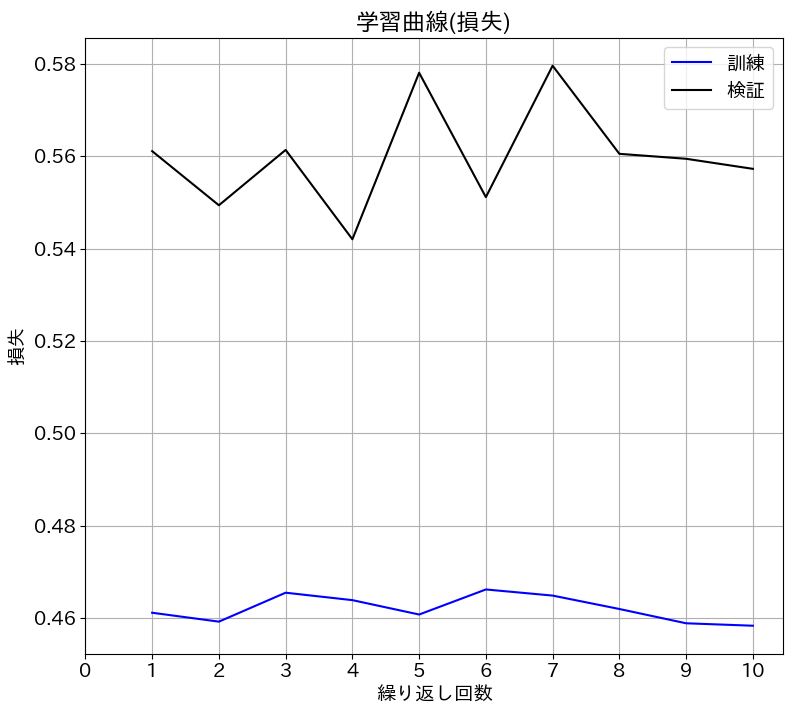

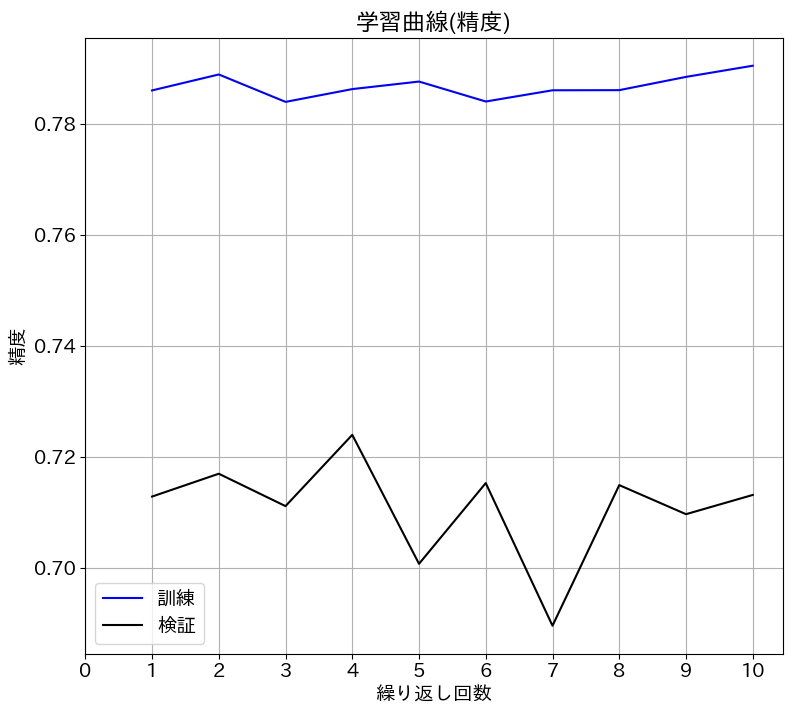

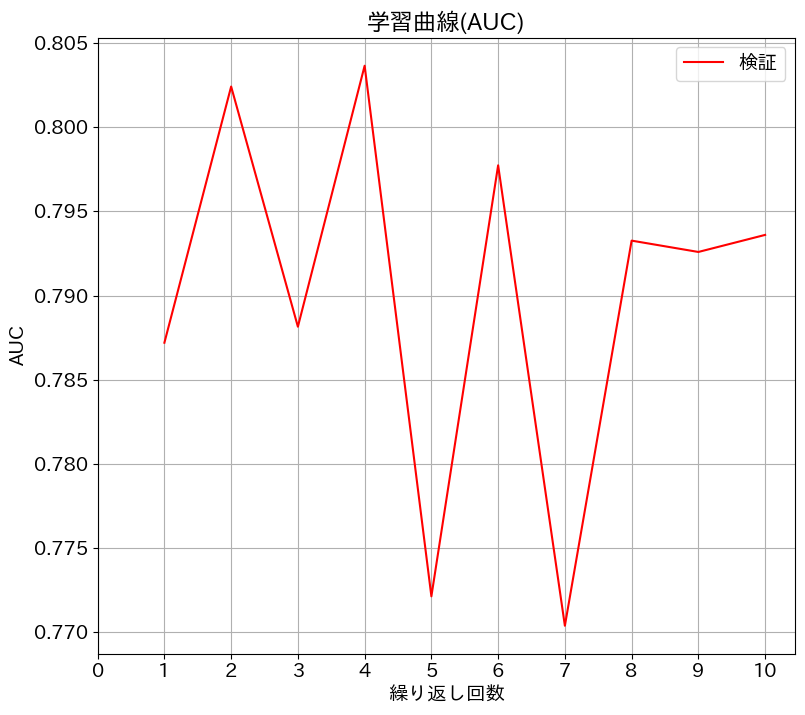

In [14]:
evaluate_history(cv_history)

初期状態: 損失: 0.55755 精度: 0.71674
最終状態: 損失: 0.54105 精度: 0.72144


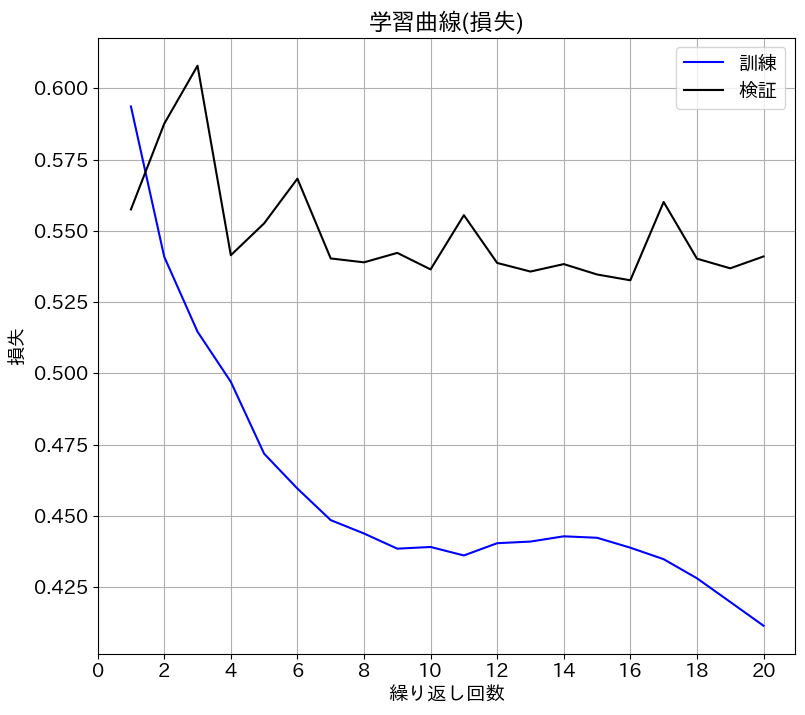

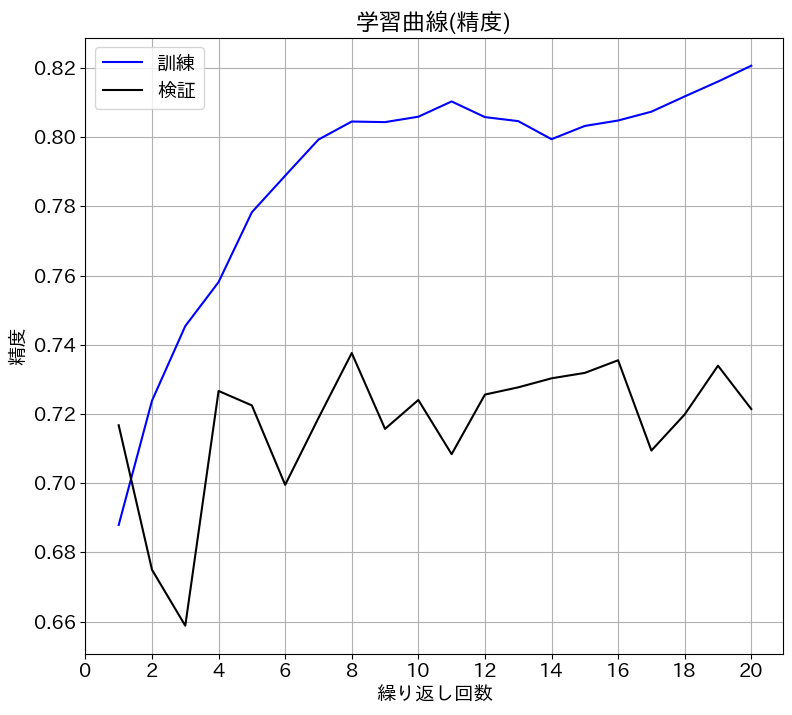

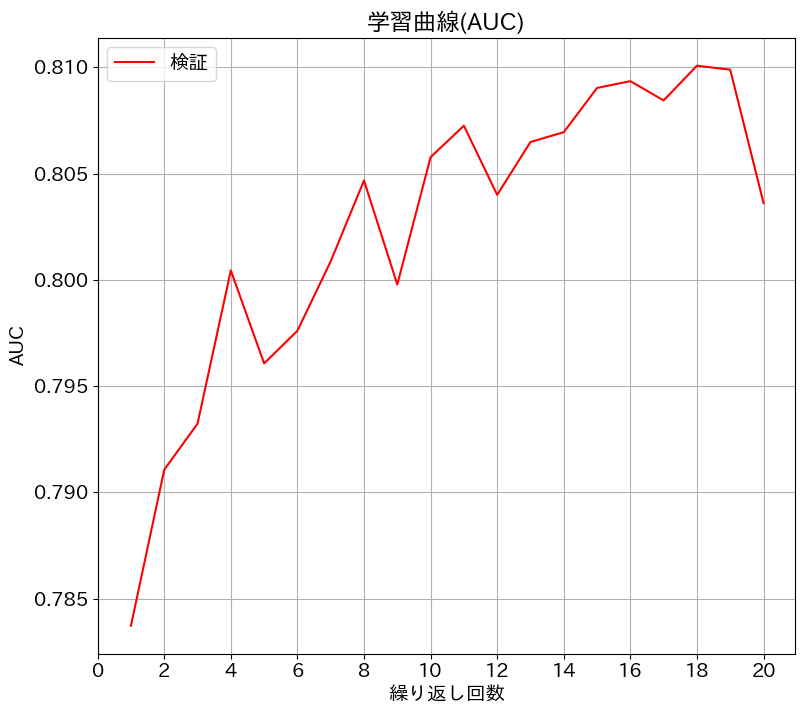

In [15]:
evaluate_history(each_history[1,:,:])

In [16]:
import pandas as pd
df = pd.read_csv('../result/threshold_2000_2.csv', index_col=False)
df

,seed,num_kf,score_type,1,2,3,4,5,6,7,...,11,12,13,14,15,16,17,18,19,20


In [20]:
score_type = ['train_loss','train_acc','test_loss','test_acc','auc_score']
for num_kf in range(num_splits):
    for i in range(5):
        AUC_list = list(each_history[num_kf,:,i+1])
        AUC_list[:0] = ['txt_vec_and_label_camel_0.csv',num_kf+1, score_type[i]]
        df.loc[len(df)] = AUC_list

In [18]:
each_history[0,:,5]

array([0.77453, 0.77648, 0.78116, 0.78502, 0.78713, 0.78711, 0.78468,
       0.78798, 0.79103, 0.79365, 0.79105, 0.78873, 0.79158, 0.78794,
       0.78926, 0.79219, 0.78689, 0.78938, 0.78982, 0.78833])

In [21]:
df.to_csv('../result/threshold_2000_camle_0.csv', index=False)